In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from itertools import product

In [152]:
T = 101
sigma = 0.01
theta = np.linspace(0, (T-1)*0.1, T)
x_seq = pd.read_csv('real.csv', header=None).values.T.astype(np.float32)
x_noise = x_seq + np.random.normal(scale=sigma, size=x_seq.shape).astype(np.float32)

x_t = torch.tensor(x_noise[:-1])
x_tp1 = torch.tensor(x_noise[1:])

In [127]:
class KoopmanAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
        self.K = nn.Parameter(torch.randn(5, 5))  # Koopman operator K

    def forward(self, x):
        z = self.encoder(x)           # z_t
        z_next_pred = z @ self.K.T   # z_{t+1} ≈ K z_t
        x_recon = self.decoder(z)    
        return z, z_next_pred, x_recon

In [ ]:
best_loss = float('inf')
best_model_state = None

model = KoopmanAutoEncoder()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 9999
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    z_t, z_tp1_pred, x_recon = model(x_t)
    z_tp1 = model.encoder(x_tp1).detach()  

    loss_recon = loss_fn(x_recon, x_t)
    loss_koop = loss_fn(z_tp1_pred, z_tp1)
    loss = loss_recon + loss_koop
    loss.backward()
    optimizer.step()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = model.state_dict()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        
model.load_state_dict(best_model_state)
model.eval()
print("Loss =", best_loss)

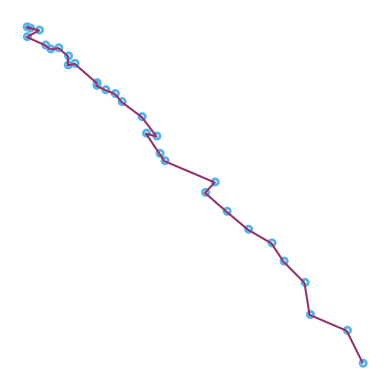

In [160]:
model.eval()
with torch.no_grad():
    z_all, _, x_recon_all = model(torch.tensor(x_noise))

z_all_np = z_all.numpy()
x_recon_all_np = x_recon_all.numpy()

plt.figure(figsize=(4, 4))

plt.plot(x_recon_all_np[:30, 0], x_recon_all_np[:30, 1], color='#94346E', linewidth=1.5, label='Median')
plt.scatter(x_noise[:30, 0], x_noise[:30, 1], facecolors='none', edgecolors='#56B4E9', s=20, linewidths=2.0, label='Test')

plt.axis('off')

plt.tight_layout()

plt.show()

In [155]:
def observable_basis(x: np.ndarray) -> np.ndarray:
    x1 = x[:, 0]
    x2 = x[:, 1]
    g_list = [x1, x2, x1 ** 2]
    return np.stack(g_list, axis=1)

def dmd(x: np.ndarray) -> np.ndarray:
    X = x[:-1].T  # x_t
    Y = x[1:].T   # x_{t+1}
    
    A = Y @ np.linalg.pinv(X)
    return A.astype(np.float32)

In [156]:
Z = observable_basis(x_noise)       # shape (T, 3)
A_edmd = dmd(Z)      # shape (3, 3)

g_pred = [Z[0]]
for _ in range(1, T):
    g_pred.append(g_pred[-1] @ A_edmd.T)
g_pred = np.stack(g_pred)

x_recon = g_pred[:, :2]

In [157]:
x_recon.shape

(101, 2)

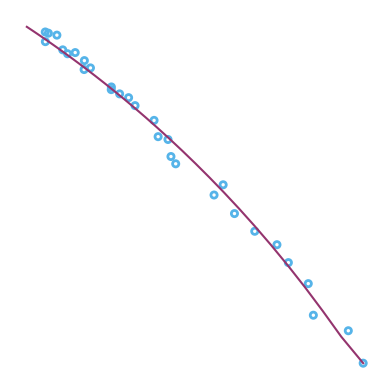

In [159]:
plt.figure(figsize=(4, 4))
plt.plot(x_recon[:30, 0], x_recon[:30, 1], color='#94346E', linewidth=1.5)
plt.scatter(x_noise[:30, 0], x_noise[:30, 1], facecolors='none', edgecolors='#56B4E9', s=20, linewidths=2.0)
plt.axis('off')
plt.tight_layout()
plt.show()